### Indian Institute of Information Technology Raichur

**Name:** K. V. Jaya Harsha  
**Roll No:** CS23B1034  
**Course:** Deep Learning for Medical Imaging  

---

#### Project 1: Brain MRI Tumor Segmentation  
##### A Comparative Study of Otsu and Sauvola Thresholding

**Dataset:** Kaggle Brain MRI Tumor Dataset  
**Objective:** Tumor region segmentation from MRI slices  
**Evaluation Metrics:** Dice Score, Jaccard Index  


In [1]:
!pip install kagglehub
!pip install opencv-python
!pip install scikit-image
!pip install matplotlib
!pip install scikit-learn
!pip install tqdm

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)


100%|██████████| 312M/312M [00:02<00:00, 121MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.filters import threshold_otsu, threshold_sauvola
from sklearn.metrics import jaccard_score


In [ ]:
image_dir = os.path.join(path, "images")
mask_dir = os.path.join(path, "masks")

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print("Total images:", len(image_files))


Total images: 3064


In [14]:
def preprocess_image(image):
    # Normalize intensities
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    
    # Contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image = clahe.apply(image.astype(np.uint8))
    
    # Gaussian smoothing
    image = cv2.GaussianBlur(image, (5,5), 0)
    
    return image


In [23]:
def extract_brain_region(image):
    # Remove dark background
    _, brain_mask = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((5,5), np.uint8)
    brain_mask = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
    
    # Keep largest connected component (brain)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(brain_mask)
    
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    brain_mask = (labels == largest_label).astype(np.uint8)
    
    return brain_mask


In [24]:
def dice_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)


In [25]:
def jaccard(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    return jaccard_score(y_true, y_pred)


In [26]:
def otsu_segmentation(image):
    image = preprocess_image(image)
    brain_mask = extract_brain_region(image)
    
    masked_pixels = image[brain_mask == 1]
    
    if len(masked_pixels) == 0:
        return np.zeros_like(image)
    
    thresh = threshold_otsu(masked_pixels)
    
    binary = (image > thresh).astype(np.uint8)
    
    # Keep only brain region
    binary = binary * brain_mask
    
    # Morph cleanup
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary


In [27]:
def sauvola_segmentation(image, window_size=35, k=0.2):
    image = preprocess_image(image)
    brain_mask = extract_brain_region(image)
    
    thresh = threshold_sauvola(image, window_size=window_size, k=k)
    binary = (image > thresh).astype(np.uint8)
    
    # Keep only brain region
    binary = binary * brain_mask
    
    # Morph cleanup
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    return binary


In [28]:
dice_otsu = []
dice_sauvola = []

jaccard_otsu = []
jaccard_sauvola = []

for img_name, mask_name in tqdm(zip(image_files, mask_files), total=len(image_files)):
    
    image = cv2.imread(os.path.join(image_dir, img_name), 0)
    mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
    
    mask = (mask > 127).astype(np.uint8)
    
    otsu_pred = otsu_segmentation(image)
    sauvola_pred = sauvola_segmentation(image)
    
    dice_otsu.append(dice_score(mask, otsu_pred))
    dice_sauvola.append(dice_score(mask, sauvola_pred))
    
    jaccard_otsu.append(jaccard(mask, otsu_pred))
    jaccard_sauvola.append(jaccard(mask, sauvola_pred))


100%|██████████| 3064/3064 [05:23<00:00,  9.48it/s]


In [29]:
print("===== FINAL RESULTS =====\n")

print("Otsu Dice:", np.mean(dice_otsu))
print("Sauvola Dice:", np.mean(dice_sauvola))

print("\nOtsu Jaccard:", np.mean(jaccard_otsu))
print("Sauvola Jaccard:", np.mean(jaccard_sauvola))


===== FINAL RESULTS =====

Otsu Dice: 0.06240726933200947
Sauvola Dice: 0.04989597195927525

Otsu Jaccard: 0.03308813275756733
Sauvola Jaccard: 0.02607373489309107


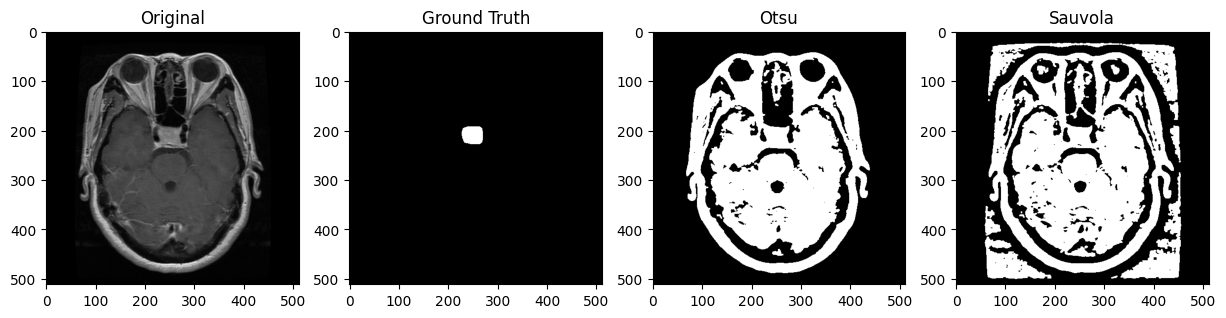

In [30]:
idx = 10

image = cv2.imread(os.path.join(image_dir, image_files[idx]), 0)
mask = cv2.imread(os.path.join(mask_dir, mask_files[idx]), 0)
mask = (mask > 127).astype(np.uint8)

otsu_pred = otsu_segmentation(image)
sauvola_pred = sauvola_segmentation(image)

plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(image, cmap='gray')

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(mask, cmap='gray')

plt.subplot(1,4,3)
plt.title("Otsu")
plt.imshow(otsu_pred, cmap='gray')

plt.subplot(1,4,4)
plt.title("Sauvola")
plt.imshow(sauvola_pred, cmap='gray')

plt.show()
